In [1]:
import calendar
import datetime
import xmlrpc.client
import csv
import pandas as pd
import phonenumbers
import psycopg2

import matplotlib.pyplot as plt

ODOO_URL = "https://smsperkasa.odoo.com"
ODOO_DB = "smsperkasa-master-1574977"
ODOO_USERNAME = "admin"
ODOO_PASSWORD = "q82fD^YMXL246cUNr2Qp{a{TN"


In [32]:
df = None

In [33]:
def search_from_odoo(model, payload, fields, order=''):
    """Mixin function to search data from Odoo with Odoo's xmlrpc"""
    try:
        common = xmlrpc.client.ServerProxy(f'{ODOO_URL}/xmlrpc/2/common')
        dbname = ODOO_DB
        user = ODOO_USERNAME
        pw = ODOO_PASSWORD

        uid = common.authenticate(dbname, user, pw, {})

        models = xmlrpc.client.ServerProxy(f'{ODOO_URL}/xmlrpc/2/object')
        
        result = models.execute_kw(
            dbname,uid,pw,
            model,'search_read',[payload],
            {
                'fields': fields, 
                'context': {'lang': 'en_GB'}, 
                'order': order
            }
        )

        return result
    except Exception as err:
        return ["Error", err]

# def convert_phonenumber(phonenumber):
#     """Function to convert phone number to the right format"""
#     if pd.isna(phonenumber) == False:
#         phone = phonenumber
#         res = ''
#         try:
#             res = phonenumbers.format_number(phonenumbers.parse(phone.replace("+69","+62"),"ID"), phonenumbers.PhoneNumberFormat.NATIONAL).replace('0', '+62 ',1)
#         except:
#             # print(phone)
#             res = phonenumbers.format_number(phonenumbers.parse(phone.replace("+","+62"),"ID"), phonenumbers.PhoneNumberFormat.NATIONAL).replace('0', '+62 ',1)
#         return res
#     else:
#         return None

def convert_phonenumber(phonenumber):
    """Function to convert phone number to the right format"""
    try:
        if phonenumber[0] == '0':
            phonenumber = '+62' + phonenumber[1:]
        parsed_phone = phonenumbers.parse(phonenumber, 'ID')
        return phonenumbers.format_number(
            parsed_phone,
            phonenumbers.PhoneNumberFormat.INTERNATIONAL
        )
    except Exception as e:
        if phonenumber is None:
            return None
        return "error"

def reverse_param(feature_param):
    if feature_param == 'cleaned_email':
        return 'cleaned_phone'
    return 'cleaned_email'

def duplicated_label(feature_param, row, depth, label):
    if depth >= 4:
        return None
    found_dup = df[(df[feature_param] == row[feature_param])]
    if len(found_dup) > 1:
        for i, r in found_dup.loc[:, [reverse_param(feature_param)]].iterrows():
            df.loc[(df[reverse_param(feature_param)] == r[reverse_param(feature_param)]), 'group_label'] = label
            duplicated_label(reverse_param(feature_param), r, depth + 1, label)
        df.loc[(df[feature_param] == row[feature_param]), 'group_label'] = label
    return None


In [34]:
conn = psycopg2.connect(
    host="167.71.206.23",
    database="chatwoot_production",
    user="postgres",
    password="s0f!a_s3xy?!",
)

cursor = conn.cursor()
query = """
SELECT * FROM contacts
WHERE
    (email IS NOT NULL AND email <> '') OR
    (phone_number IS NOT NULL AND phone_number <> '')
ORDER BY id
"""
cursor.execute(query)

records = cursor.fetchall()
cursor.close()

raw_cw_df = pd.DataFrame(records, columns=['id', 'name', 'email', 'phone_number', 'account_id', 'created_at', 'updated_at', 'additional_attributes', 'identifier', 'custom_attributes', 'last_activity_at'])
cw_df = raw_cw_df
cw_df.rename(columns={
    'created_at': 'create_date',
    'phone_number': 'phone',
    'email': 'cleaned_email'
}, inplace=True)
cw_df = cw_df.replace('', None)
cw_df['create_date'] = pd.to_datetime(cw_df['create_date'], errors='coerce')
cw_df['cleaned_phone'] = cw_df.apply(lambda x: convert_phonenumber(x.phone), axis=1)
cw_df = cw_df[cw_df.cleaned_phone != 'error']

In [35]:
odoo_contacts = search_from_odoo(
    'res.partner',
    [
        ['email', 'not like', 'smsperkasa'],
    ],
    ['id', 'name', 'email', 'phone', 'mobile', 'create_date']
)
raw_odoo_contacts_df = pd.DataFrame(odoo_contacts)

odoo_contacts_df = raw_odoo_contacts_df.replace('', None)
odoo_contacts_df = odoo_contacts_df.replace(False, None)
odoo_contacts_df['create_date'] = pd.to_datetime(odoo_contacts_df['create_date'], errors='coerce')

odoo_contacts_df[['phone1', 'phone2', 'phone3']] = odoo_contacts_df['phone'].str.split(r'[,/<>;]+', expand=True)
odoo_contacts_df = odoo_contacts_df.melt(id_vars=['id', 'name', 'email', 'phone', 'mobile', 'create_date'], value_vars=['phone1', 'phone2', 'phone3'], value_name='cleaned_phone')
odoo_contacts_df = odoo_contacts_df[~(((odoo_contacts_df.cleaned_phone.isna()) | (odoo_contacts_df.cleaned_phone.str.strip() == "")) & ((odoo_contacts_df.variable == 'phone2') | (odoo_contacts_df.variable == 'phone3')))]
odoo_contacts_df.drop(columns='variable', inplace=True)

tmp_contact_copy = odoo_contacts_df
work_phones = tmp_contact_copy[['id', 'name', 'email', 'phone', 'create_date', 'cleaned_phone']]
other_phones = (
    tmp_contact_copy[~tmp_contact_copy.mobile.isna()]['mobile'].str.split(',')
    .explode()
    .to_frame('cleaned_phone')
    
    # grab the correct name from the original DataFrame
    .join(tmp_contact_copy[['id', 'name', 'email', 'phone', 'create_date']])
)

tmp_combined_contact = pd.concat([work_phones, other_phones]).reset_index(level=0)
sorted_contacts_df = tmp_combined_contact.sort_values('create_date', ascending=False)
sorted_contacts_df = sorted_contacts_df.drop_duplicates(subset=['id', 'name', 'email', 'phone', 'create_date', 'cleaned_phone'], keep='last')
sorted_contacts_df = sorted_contacts_df[['id', 'name', 'email', 'phone', 'create_date', 'cleaned_phone']]

sorted_contacts_df[['email1', 'email2', 'email3']] = sorted_contacts_df['email'].str.split(r'[ ,/<>]+', expand=True)
sorted_contacts_df = sorted_contacts_df.melt(id_vars=['id', 'name', 'email', 'phone', 'create_date', 'cleaned_phone'], value_vars=['email1', 'email2', 'email3'], value_name='cleaned_email')
sorted_contacts_df = sorted_contacts_df[~(((sorted_contacts_df.cleaned_email.isna()) | (sorted_contacts_df.cleaned_email.str.strip() == "")) & ((sorted_contacts_df.variable == 'email2') | (sorted_contacts_df.variable == 'email3')))]
sorted_contacts_df.drop(columns='variable', inplace=True)

sorted_contacts_df['cleaned_phone'] = sorted_contacts_df.apply(lambda x: convert_phonenumber(x.cleaned_phone), axis=1)

In [36]:
odoo_leads = search_from_odoo(
    'crm.lead',
    [
        "&", "|", ["active", "=", True], ["active", "=", False], ["type", "=", "lead"]
    ],
    ['id', 'name', 'email_from', 'phone', 'create_date', 'type']
)
raw_odoo_leads_df = pd.DataFrame.from_dict(odoo_leads)
odoo_leads_df = raw_odoo_leads_df
odoo_leads_df.rename(columns={
    'email_from': 'cleaned_email'
}, inplace=True)
odoo_leads_df = odoo_leads_df.replace('', None)
odoo_leads_df = odoo_leads_df.replace(False, None)
odoo_leads_df['create_date'] = pd.to_datetime(odoo_leads_df['create_date'], errors='coerce')
odoo_leads_df['cleaned_phone'] = odoo_leads_df.apply(lambda x: convert_phonenumber(x.phone), axis=1)

In [37]:
selected_cw_df = cw_df[['id', 'name', 'cleaned_email', 'cleaned_phone', 'create_date']]
selected_odoo_contacts_df = sorted_contacts_df[['id', 'name', 'cleaned_email', 'cleaned_phone', 'create_date']]
selected_odoo_leads_df = odoo_leads_df[['id', 'name', 'cleaned_email', 'cleaned_phone', 'create_date']]

In [38]:
joined_contacts = pd.concat([selected_cw_df, selected_odoo_contacts_df, selected_odoo_leads_df])
joined_contacts = joined_contacts[(~joined_contacts.cleaned_email.isna()) | (~joined_contacts.cleaned_phone.isna())]
joined_contacts['cleaned_email'] = joined_contacts['cleaned_email'].str.lower()
joined_contacts = joined_contacts.sort_values(by='create_date', ascending=False)
joined_contacts = joined_contacts.drop_duplicates(subset=['cleaned_email', 'cleaned_phone'], keep='last')

In [39]:
df = joined_contacts
df['group_label'] = None

In [40]:
for index, row in df.iterrows():
    found_dup = df[(df.cleaned_email == row.cleaned_email)]
    if len(found_dup) > 1:
        label = found_dup.reset_index().at[0, 'id']
        duplicated_label('cleaned_email', row, 1, label)

In [41]:
for index, row in df.iterrows():
    found_dup = df[(df.cleaned_phone == row.cleaned_phone)]
    if len(found_dup) > 1:
        label = found_dup.reset_index().at[0, 'id']
        duplicated_label('cleaned_phone', row, 1, label)

In [42]:
duplicated_df = df[~df.group_label.isna()]
non_duplicated_df = df[df.group_label.isna()]
filtered_duplicated_df = duplicated_df.drop_duplicates(subset='group_label', keep='last')

In [43]:
date_range_2023 = filtered_duplicated_df[(filtered_duplicated_df['create_date'] >= '2023-10-01') & (filtered_duplicated_df['create_date'] <= '2023-12-31')]
filtered_duplicated_mql_2023 = date_range_2023.groupby([date_range_2023['create_date'].dt.date.rename('date')]).agg({'count'})['create_date']

date_range_2023 = non_duplicated_df[(non_duplicated_df['create_date'] >= '2023-10-01') & (non_duplicated_df['create_date'] <= '2023-12-31')]
non_duplicated_mql_2023 = date_range_2023.groupby([date_range_2023['create_date'].dt.date.rename('date')]).agg({'count'})['create_date']

In [44]:
mql_target_total = 6000
days_total = 91
mql_daily_target = mql_target_total / days_total

In [45]:
daily_mql = non_duplicated_mql_2023.add(filtered_duplicated_mql_2023, fill_value=0)
daily_mql = daily_mql.reset_index()
daily_mql.rename(columns={
    'count': 'mql'
}, inplace=True)
daily_mql['agg_mql'] = daily_mql['mql'].cumsum()
daily_mql['daily_target'] = mql_daily_target
daily_mql['agg_daily_target'] = daily_mql['daily_target'].cumsum()
daily_mql['daily_percentage'] = daily_mql['agg_mql'] / daily_mql['agg_daily_target'] * 100
daily_mql['mql_target_total'] = mql_target_total
daily_mql['achivement_percentage'] = daily_mql['agg_mql'] / daily_mql['mql_target_total'] * 100

daily_mql_report = daily_mql

start_date = pd.Timestamp(daily_mql['date'].max() + datetime.timedelta(days=1))
end_date = pd.Timestamp('2023-12-31')
date_range = pd.date_range(start_date, end_date, freq='D')

extended_data = {'date': date_range, 'mql': [None] * len(date_range), 'agg_mql': [None] * len(date_range), 'daily_target': [None] * len(date_range), 'agg_daily_target': [None] * len(date_range), 'daily_percentage': [None] * len(date_range), 'mql_target_total': [None] * len(date_range), 'achivement_percentage': [None] * len(date_range)}
extended_df = pd.DataFrame(extended_data)

daily_mql = pd.concat([daily_mql, extended_df])
daily_mql['daily_target'] = mql_daily_target
daily_mql['agg_daily_target'] = daily_mql['daily_target'].cumsum()

daily_mql = daily_mql.sort_values(by='date')

/Users/bcw-003/.virtualenvs/mql-project-dashboard/lib/python3.9/site-packages/pandas/core/sorting.py:417: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  indexer = non_nan_idx[non_nans.argsort(kind=kind)]


In [2]:
start_date = '2023-10-01'
end_date = '2023-12-31'

date_range = pd.date_range(start=start_date, end=end_date, freq='D')
date_array = date_range.date
x_axis = date_array.tolist()

y_axis_actual = []
for data in daily_mql.values:
    try:
        y_axis_actual.append(data[2])
    except:
        y_axis_actual.append(None)


y_axis_target = []
for data in daily_mql.values:
    try:
        y_axis_target.append(data[4])
    except:
        y_axis_target.append(None)

# desired_length = len(x_axis)
# num_zeros = max(0, desired_length - len(y_axis_actual))
# y_axis_actual = y_axis_actual + [0] * num_zeros

# num_zeros = max(0, desired_length - len(y_axis_target))
# y_axis_target = y_axis_target + [0] * num_zeros

NameError: name 'daily_mql' is not defined

Google Analytics Data

In [3]:
conn = psycopg2.connect(
    host="178.128.83.235",
    database="warehouse_db",
    user="postgres",
    password="s0f!a_s3xy?!",
)

cursor = conn.cursor()
query = """
SELECT uuid, date, unifiedpagepathscreen, engagedsessions, sessions, conversions, totalusers, engagementrate, userconversionrate, activeusers, userengagementduration, screenpageviews 
FROM g_analytics.pages_and_screens_____path_and_screen_class
WHERE
    unifiedpagepathscreen LIKE '/produk/%'
"""
cursor.execute(query)

g_anal_records = cursor.fetchall()
cursor.close()

In [4]:
raw_ga_df = pd.DataFrame(g_anal_records, columns=['uuid', 'date', 'unifiedpagepathscreen', 'engagedsessions', 'sessions', 'conversions', 'totalusers', 'engagementrate', 'userconversionrate', 'activeusers', 'userengagementduration', 'screenpageviews'])
ga_df = raw_ga_df
ga_df['date'] = pd.to_datetime(ga_df['date'], format='%Y%m%d')

In [5]:
engaged_sessions = ga_df.groupby('date')['engagedsessions'].sum()
sessions = ga_df.groupby('date')['sessions'].sum()

conversions = ga_df.groupby('date')['conversions'].sum()
totalusers = ga_df.groupby('date')['totalusers'].sum()

In [6]:
daily_engagement_rate = engaged_sessions.divide(sessions, fill_value=0)
daily_conversion_rate = conversions.divide(totalusers, fill_value=0)

daily_engagement_rate = daily_engagement_rate.reset_index(name='engagement_rate')
daily_conversion_rate = daily_conversion_rate.reset_index(name='conversion_rate')

daily_engagement_rate['engagement_rate'] = daily_engagement_rate['engagement_rate'] * 100
daily_conversion_rate['conversion_rate'] = daily_conversion_rate['conversion_rate'] * 100

daily_engagement_rate['target'] = 61.01
daily_conversion_rate['target'] = 1.298

daily_engagement_rate_report = daily_engagement_rate
daily_conversion_rate_report = daily_conversion_rate

In [7]:
y_axis_engagement_actual = []
for data in daily_engagement_rate.values:
    try:
        y_axis_engagement_actual.append(data[1])
    except:
        y_axis_engagement_actual.append(None)


y_axis_engagement_target = []
for data in daily_engagement_rate.values:
    try:
        y_axis_engagement_target.append(data[2])
    except:
        y_axis_engagement_target.append(None)

desired_length = len(x_axis)
num_zeros = max(0, desired_length - len(y_axis_engagement_actual))
y_axis_engagement_actual = y_axis_engagement_actual + [None] * num_zeros

num_zeros = max(0, desired_length - len(y_axis_engagement_target))
y_axis_engagement_target = y_axis_engagement_target + [61.01] * num_zeros


y_axis_conversion_actual = []
for data in daily_conversion_rate.values:
    try:
        y_axis_conversion_actual.append(data[1])
    except:
        y_axis_conversion_actual.append(None)


y_axis_conversion_target = []
for data in daily_conversion_rate.values:
    try:
        y_axis_conversion_target.append(data[2])
    except:
        y_axis_conversion_target.append(None)

desired_length = len(x_axis)
num_zeros = max(0, desired_length - len(y_axis_conversion_actual))
y_axis_conversion_actual = y_axis_conversion_actual + [None] * num_zeros

num_zeros = max(0, desired_length - len(y_axis_conversion_target))
y_axis_conversion_target = y_axis_conversion_target + [1.298] * num_zeros

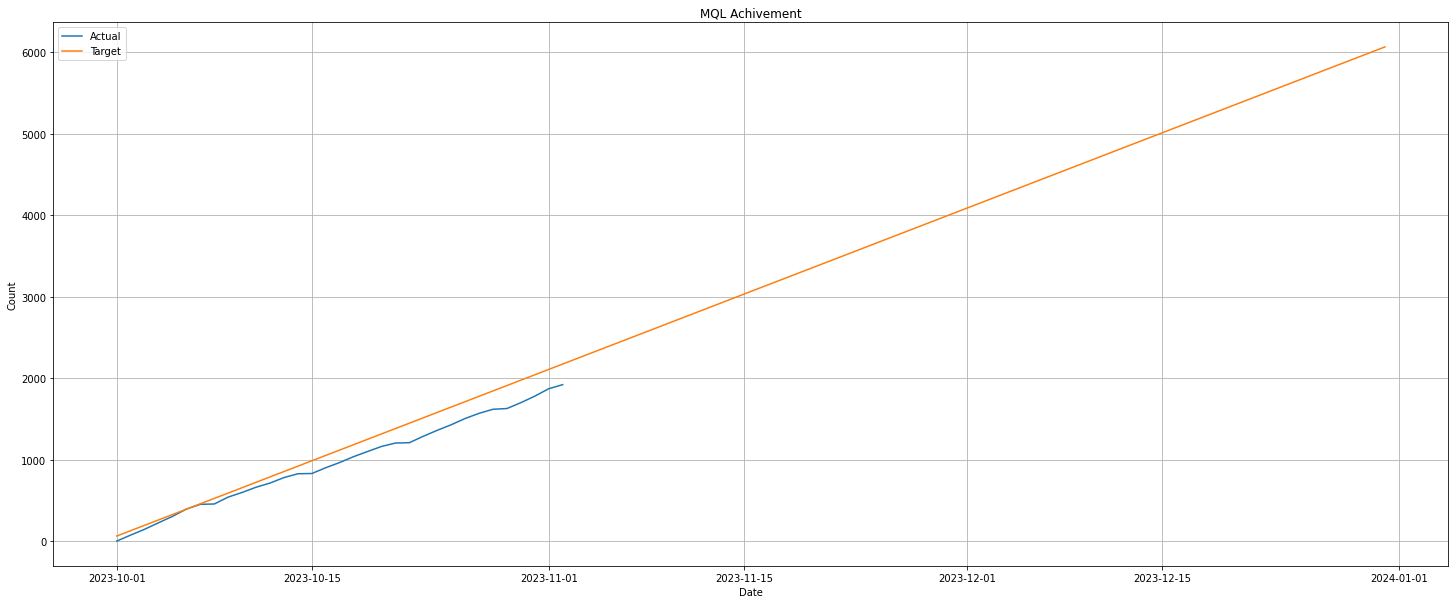

In [52]:
plt.figure(figsize=(25,10))
plt.title("MQL Achivement")
plt.grid()
plt.plot(x_axis,y_axis_actual, label="Actual")

plt.plot(x_axis,y_axis_target, label="Target")

plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.show()

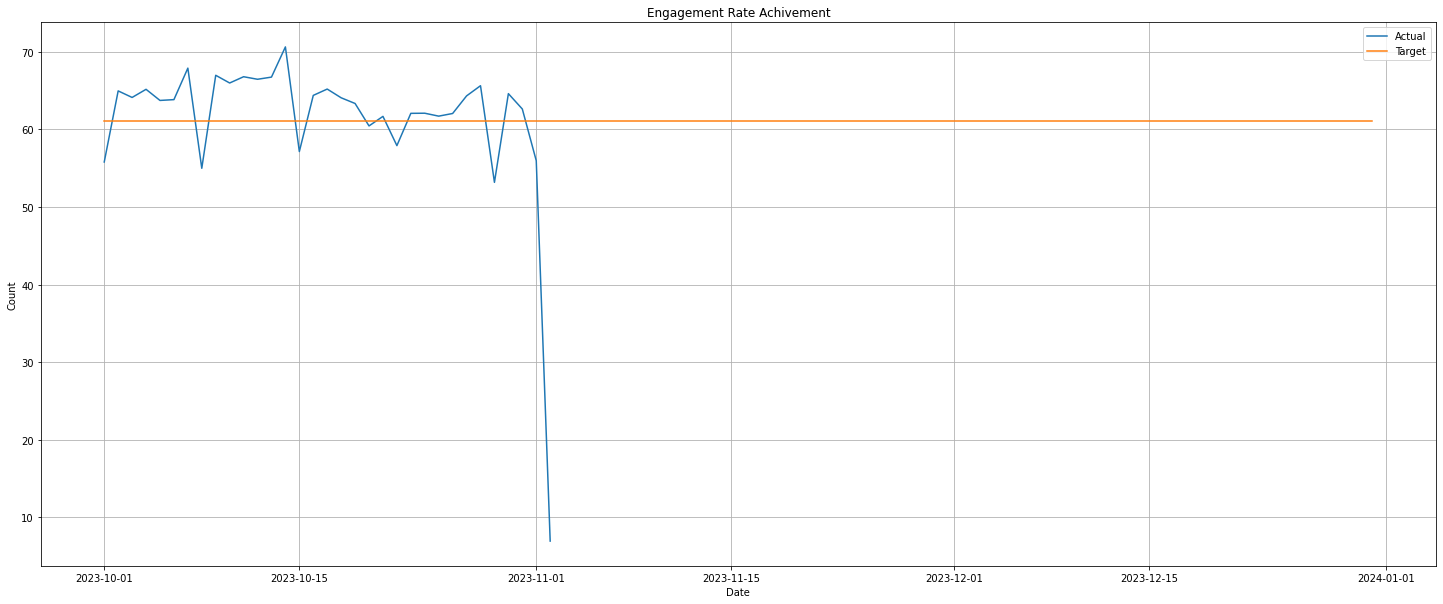

In [53]:
plt.figure(figsize=(25,10))
plt.title("Engagement Rate Achivement")
plt.grid()
plt.plot(x_axis,y_axis_engagement_actual, label="Actual")

plt.plot(x_axis,y_axis_engagement_target, label="Target")

plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.show()

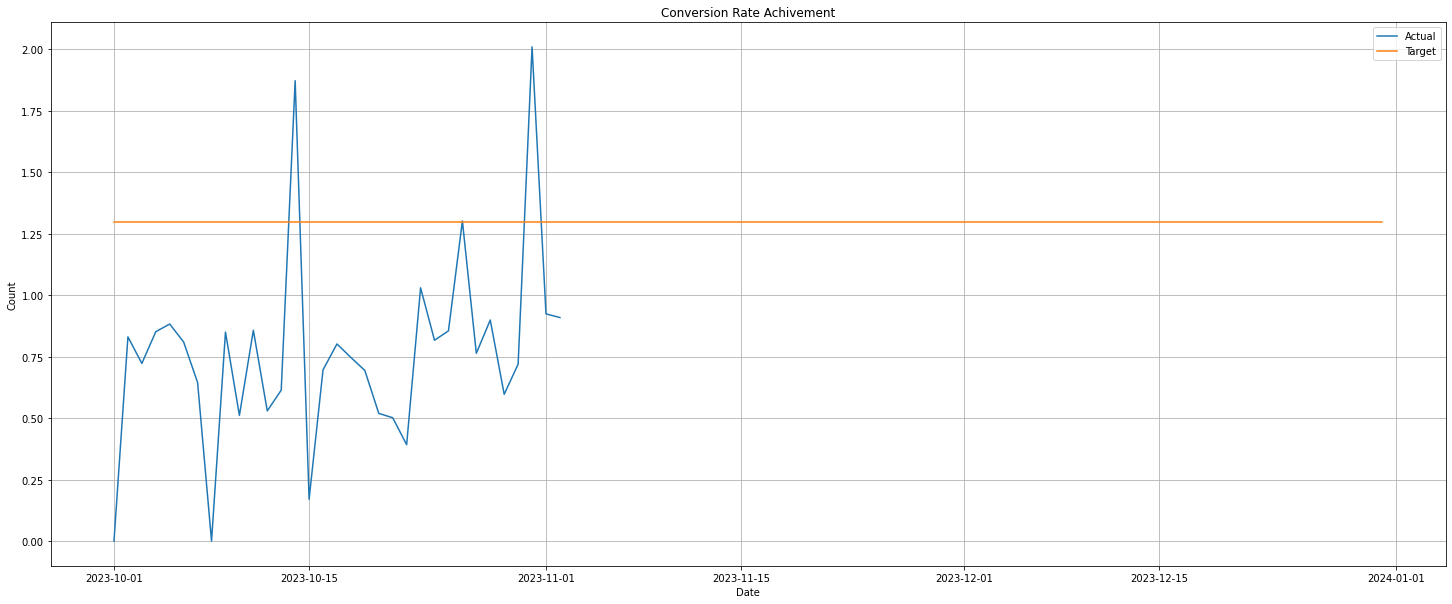

In [8]:
plt.figure(figsize=(25,10))
plt.title("Conversion Rate Achivement")
plt.grid()
plt.plot(x_axis,y_axis_conversion_actual, label="Actual")

plt.plot(x_axis,y_axis_conversion_target, label="Target")

plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.show()

In [55]:
daily_mql_report

,date,mql,agg_mql,daily_target,agg_daily_target,daily_percentage,mql_target_total,achivement_percentage
0,2023-10-01,4.0,4.0,65.934066,65.934066,6.066667,6000,0.066667
1,2023-10-02,74.0,78.0,65.934066,131.868132,59.150000,6000,1.300000
2,2023-10-03,71.0,149.0,65.934066,197.802198,75.327778,6000,2.483333
3,2023-10-04,80.0,229.0,65.934066,263.736264,86.829167,6000,3.816667
4,2023-10-05,78.0,307.0,65.934066,329.670330,93.123333,6000,5.116667
5,2023-10-06,90.0,397.0,65.934066,395.604396,100.352778,6000,6.616667
6,2023-10-07,58.0,455.0,65.934066,461.538462,98.583333,6000,7.583333
7,2023-10-08,4.0,459.0,65.934066,527.472527,87.018750,6000,7.650000
8,2023-10-09,85.0,544.0,65.934066,593.406593,91.674074,6000,9.066667
9,2023-10-10,57.0,601.0,65.934066,659.340659,91.151667,6000,10.016667


In [56]:
daily_engagement_rate_report

,date,engagement_rate,target
0,2023-10-01,55.775578,61.01
1,2023-10-02,64.932615,61.01
2,2023-10-03,64.089258,61.01
3,2023-10-04,65.136549,61.01
4,2023-10-05,63.704819,61.01
5,2023-10-06,63.807938,61.01
6,2023-10-07,67.865391,61.01
7,2023-10-08,54.966887,61.01
8,2023-10-09,66.943651,61.01
9,2023-10-10,65.949119,61.01


In [57]:
daily_conversion_rate_report

,date,conversion_rate,target
0,2023-10-01,0.000000,1.298
1,2023-10-02,0.830614,1.298
2,2023-10-03,0.722543,1.298
3,2023-10-04,0.851621,1.298
4,2023-10-05,0.882852,1.298
5,2023-10-06,0.809465,1.298
6,2023-10-07,0.644930,1.298
7,2023-10-08,0.000000,1.298
8,2023-10-09,0.849941,1.298
9,2023-10-10,0.510949,1.298
